# MILESTONE 2

## i. Perkenalan
### Muhammad Fadhil Sadeli
### BATCH 002

## ii. Import Libraries

`Memasukkan library yang digunakan`

In [1]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, RepeatVector, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

` Mengambil data set dari link berikut http://www.manythings.org/anki/deu-eng.zip`

In [2]:
!wget http://www.manythings.org/anki/deu-eng.zip -O deu-eng.zip
!unzip deu-eng.zip

--2022-12-12 07:28:25--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9601643 (9.2M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   9.16M  24.8MB/s    in 0.4s    

2022-12-12 07:28:26 (24.8 MB/s) - ‘deu-eng.zip’ saved [9601643/9601643]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


## iii. Data Loading

`Import dataset`

In [3]:
df = pd.read_table( 'deu.txt' , names=[ 'eng' , 'deu' ] )
df.reset_index( level=0 , inplace=True )
df.rename( columns={ 'index' : 'eng' , 'eng' : 'deu' , 'deu' : 'c' } , inplace=True )
df = df.drop( 'c' , 1 )
df = df.iloc[: 50000 ] 
df.head()


,eng,deu
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


`Mengganti nama kolom sesuai isinya, menghapus kolom yang tidak diperlukan dan hanya menggunakan 50000 baris saja karena keterbatasan waktu dalam pengerjaan`

In [4]:
df.tail()

,eng,deu
49995,They're best friends.,Sie sind beste Freunde.
49996,They're closed today.,Sie haben heute geschlossen.
49997,They're coming again.,Sie kommen wieder.
49998,They're coming again.,Die kommen wieder.
49999,They're doing it now.,Sie tun es jetzt.


In [5]:
print(f'English total data :' , len(df['eng']))
print(f'German total data :', len(df['deu']))

English total data : 50000
German total data : 50000


`Masing masing bahasa memiliki 50000 baris data`

In [6]:
df.isnull().sum()

eng    0
deu    0
dtype: int64

` Tidak ada missing value`

In [7]:
df.duplicated().sum()

0

`Tidak ada data yang duplicate`

# iv. Exploratory Data Analysis (EDA)

## Visualisasi kata bahasa Inggris

`Representasi grafik dari frekuensi kata bahasa Inggris yang sering muncul`

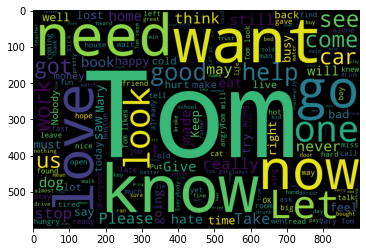

In [8]:
wc = WordCloud(width=900,height=600).generate(' '.join(df.eng))
plt.imshow(wc);

`Dapat dilihat pada gambar diatas, kata bahasa inggris yang sering muncul adalah tom, need, want, love, know, now, let, now, go, dan one`

## Visualisasi kata bahasa German

`Representasi grafik dari frekuensi kata bahasa German yang sering muncul`

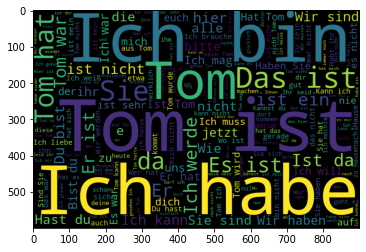

In [9]:
wc = WordCloud(width=900,height=600).generate(' '.join(df.deu))
plt.imshow(wc);

`Sedangkan pada kata bahasa german yang sering muncul adalah tom, ich, bin, habe, dan ist`

## Visualisasi kata berdasarkan grafik

`Berikut visulisasi tiap bahasa dengan grafik`

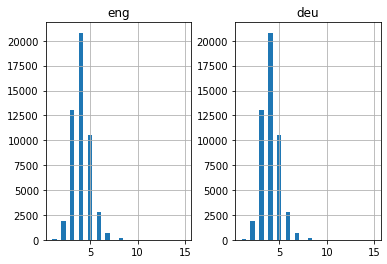

In [52]:
eng_l = []
nld_l = []

# populate the lists with sentence lengths
for i in df.deu :
      eng_l.append(len(i.split()))

for i in df.deu:
      nld_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':nld_l})

length_df.hist(bins = 30)
plt.show()

`Dikedua bahasa mempunyai proporsi yang sama, sesuai dengan panjang kata di masing masing kalimatnya. Kalimat yang mempunyai 4 kata merupakan kalimat yang paling sering muncul baik dibahasa inggris maupun bahasa german`

## Data cleaning

`Melakukan pembersihan data seperti hurufnya tidak ada yg kapital, menghapus spasi dan menghapus tanda baca atau punctuation dengan membuat fungsi sederhana`

In [10]:
def clean_text(text):
    text = text.lower()  
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    text = re.sub('([.,!?()\"])', r' \1 ', text)
    text = re.sub('\s{2,}', ' ', text)
    return text

`Selanjutnya fungsi tersebut diimplementasi pada data bahasa inggris dan data bahasa jerman`

In [11]:
df.eng = df.eng.apply(clean_text)
df.deu = df.deu.apply(clean_text)

In [53]:
df.eng.head()

0     go
1     hi
2     hi
3    run
4    run
Name: eng, dtype: object

In [12]:
df.deu.head()

0          geh
1        hallo
2    grüß gott
3         lauf
4         lauf
Name: deu, dtype: object

`Sudah dapat dilihat diatas, tidak ada lagi huruf yang kapital dan tidak terdapat tanda baca`

# v. Data Preprocess

## English

`Selanjutnya melakukan preprocesing pada bahasa Inggris`

In [13]:
#Memisahkan suatu kalimat menjadi kata agar model dapat belajar dengan mudah
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df.eng)

#mencari jumlah kosakata bahasa inggris pada data
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

5990

`Jumlah kosakata bahasa inggris pada data sebanyak 5990 kata`

`Selanjutnya mencari jumlah kata yang paling panjang disuatu kalimat bahasa inggris`

In [14]:
eng_sequences = eng_tokenizer.texts_to_sequences(df.eng)
length_list = []
for i in eng_sequences:
    length_list.append(len(i))
    
max_input_length = np.array(length_list).max()
print( 'English max length is {}'.format( max_input_length ))


English max length is 7


`Jumlah kata yang paling panjang disatu kalimat bahasa inggris adalah 7 kata`

In [ ]:
#save tokenizer
pickle.dump(eng_tokenizer, open('eng_tokenizer.pkl', 'wb'))

## German

`Selanjutnya menambahkan kata start pada awal kalimat dan kata end pada akhir kalimat agar model lebih mudah dalam menyusun kata pada training`

In [16]:
german_dec = df['deu'].apply(lambda x: '<START> ' + x + ' <END>')

`Selanjutnya melakukan preprocesing pada bahasa German`

In [17]:
#Memisahkan suatu kalimat menjadi kata agar model dapat belajar dengan mudah
deu_tokenizer = Tokenizer()
deu_tokenizer.fit_on_texts(german_dec)

In [18]:
#mencari jumlah kosakata bahasa inggris pada data
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_vocab_size

9939

`Jumlah kosakata bahasa german pada data sebanyak 9939 kata`

`Selanjutnya mencari jumlah kata yang paling panjang disuatu kalimat bahasa german`

In [19]:
deu_sequences = deu_tokenizer.texts_to_sequences(german_dec)
length_list = []
for i in deu_sequences:
    length_list.append(len(i))
    
max_input_length = np.array(length_list).max()
print( 'Dutch max length is {}'.format( max_input_length ))

Dutch max length is 17


`Jumlah kata yang paling panjang disatu kalimat bahasa german adalah 17 kata`

In [20]:
#save tokenizer
pickle.dump(deu_tokenizer, open('deu_tokenizer.pkl', 'wb'))

## Maximum Length

`Menginisialisasi maksimum jumlah kata disatu kalimat sebanayak 14. Karena jumlah kata kedua bahasa tidak sama, jadi diambil angka yang berada di tengah tengahnya yaitu 14`

In [21]:
max_eng_len = 14
max_deu_len = 14

## Padding

`Agar jumlah kata disetiap inputnya sama maka diperlukan padding dengan jumlah maksimumnya 14`

In [22]:
#padding data
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')
deu_pad_sequences = pad_sequences(deu_sequences,maxlen=max_deu_len,dtype='int32',padding='post',truncating='post')

## Data Splitting

`Lalu data dibagi menjadi 2, x untuk bahasa inggris dan y untuk bahasa jerman dengan presentasi 80% untuk data train dan 20% untuk data test`

In [23]:
#split data
X_train, X_test, y_train, y_test = train_test_split(eng_pad_sequences,deu_pad_sequences,test_size=0.2,shuffle=True,random_state=42)


In [24]:
print(f'X_train shape : ',X_train.shape)
print(f'X_test shape : ',X_test.shape)

print(f'y_train shape : ',y_train.shape)
print(f'y_test shape : ',y_test.shape)

X_train shape :  (40000, 14)
X_test shape :  (10000, 14)
y_train shape :  (40000, 14)
y_test shape :  (10000, 14)


`Dilihat dari bentuk datanya, data yg sudah displit sudah mempunyai baris yang sama di data x train dan y train, begitu juga dengan x test dan y test`

# vi. Model Definition

## Base Model

`Selanjutnya membuat arsitektur base model` 

In [25]:
#model arsitektur
K.clear_session()

latent_dim = 64
embedding_dim = 32

#model encoder
encoder_inputs = Input(shape=(None,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb)
encoder_states = [state_h,state_c]

#model decoder
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(deu_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 

decoder_dense = TimeDistributed(Dense(deu_vocab_size,activation='softmax'))
decoder_output = decoder_dense(decoder_outputs)

model1 = Model([encoder_inputs, decoder_inputs], decoder_output)
model1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     191680      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     318048      ['input_2[0][0]']                
                                                                                              

`Pada base model menggunakan parameter dengan total sebanyak 1,205,427`

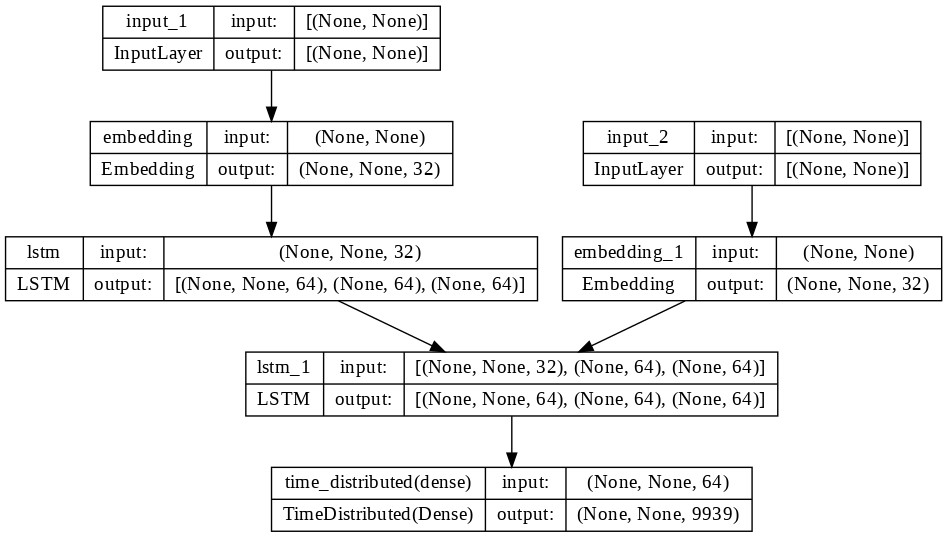

In [26]:
plot_model(model1,'model1.png',show_shapes=True,dpi=100)

`Selanjutnya model dicompile dengan loss functionnya sparse_categorical_crossentropy dan optimizernya adam`

In [27]:
#compile model
model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')

### Training

`Setalah dibangun arsitektur modelnya, selanjutnya dilakukan training dengan epoch sebanyak 30`

In [28]:
#train model
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=3,factor=0.1,min_lr=0.001)

base_model_r = model1.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=30,
             batch_size=64,
             callbacks=[es,rl],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/30
625/625 [==============================] - 22s 23ms/step - loss: 2.6431 - accuracy: 0.6621 - val_loss: 1.9298 - val_accuracy: 0.7169 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 14s 22ms/step - loss: 1.8144 - accuracy: 0.7288 - val_loss: 1.7182 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 14s 23ms/step - loss: 1.6230 - accuracy: 0.7543 - val_loss: 1.5700 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 15s 23ms/step - loss: 1.4845 - accuracy: 0.7700 - val_loss: 1.4689 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 15s 24ms/step - loss: 1.3823 - accuracy: 0.7797 - val_loss: 1.3989 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 15s 25ms/step - loss: 1.2972 - accuracy: 0.7880 - val_loss: 1.3335 - val_accuracy: 0.7903 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 14s 

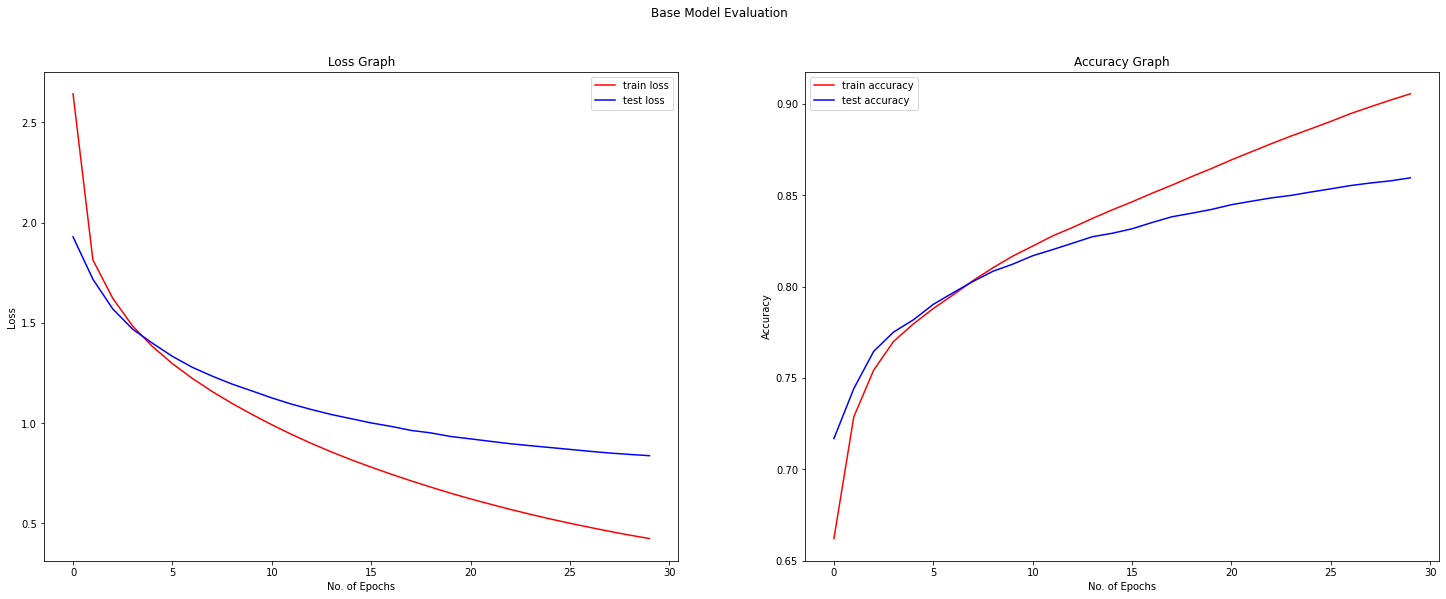

In [29]:
#plot model
fig, ax = plt.subplots(1,2, figsize=(25,9))
plt.suptitle('Base Model Evaluation')

plt.subplot(1,2,1)
plt.plot(base_model_r.history['loss'],'r',label='train loss')
plt.plot(base_model_r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

plt.subplot(1,2,2)
plt.plot(base_model_r.history['accuracy'],'r',label='train accuracy')
plt.plot(base_model_r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

plt.show()

`Dilihat dari hasilnya, base model sudah cukup baik tetapi masih terbilang sedikit overfitting`

## Improvement Model

`Selanjutnya melakukan improvement pada base model agar tidak terjadi overfitting dengan menambahkan layer batchnormalization, memambahkan dropout sebanyak 0.5, dan mengganti optimizer dengan rmsprop`

In [30]:
#model architecture
K.clear_session()

#model encoder
latent_dim = 64
embedding_dim = 32

encoder_inputs = Input(shape=(None,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim,trainable=True)(encoder_inputs)

encoder_BN_2 = BatchNormalization()(encoder_emb)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_BN_2)
encoder_states = [state_h,state_c]

#model decoder
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(deu_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_BN_3 = BatchNormalization()(decoder_emb)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_BN_3, initial_state=encoder_states) 

decoder_dense = TimeDistributed(Dense(deu_vocab_size,activation='softmax'))
decoder_output = decoder_dense(decoder_outputs)

model2 = Model([encoder_inputs, decoder_inputs], decoder_output)
model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     191680      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     318048      ['input_2[0][0]']                
                                                                                              

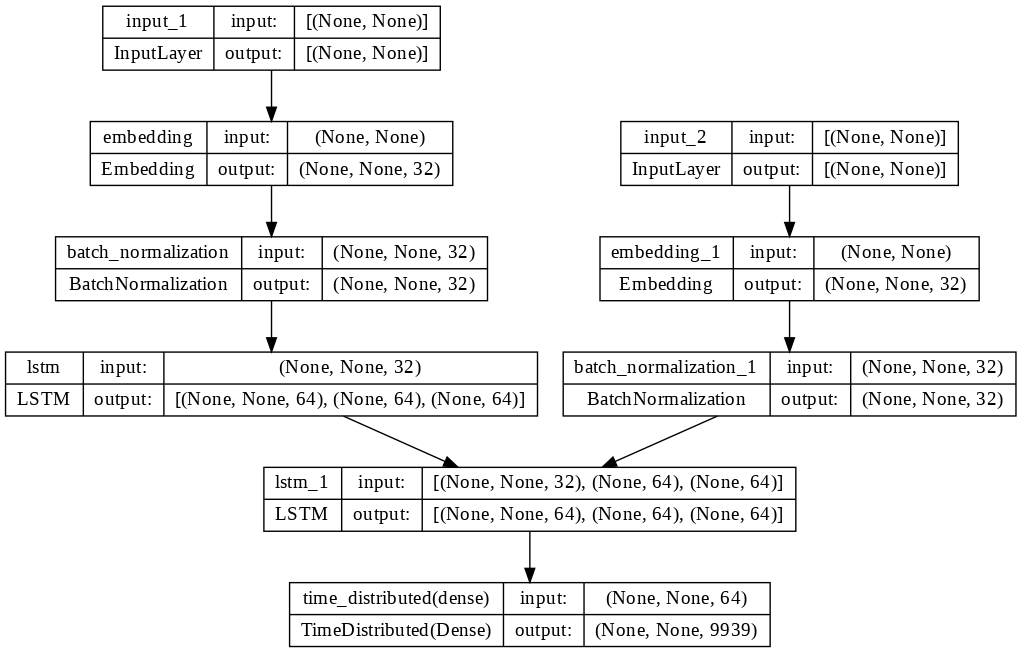

In [31]:
plot_model(model2,'model2.png',show_shapes=True,dpi=100)

In [32]:
#compile model
model2.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

`Setalah dibangun arsitektur model yang telah diimprove, selanjutnya dilakukan training dengan epoch sebanyak 30`

### Training

In [33]:
#train model
improve_model_r = model2.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=30,
             batch_size=64,
             callbacks=[es,rl],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/30
625/625 [==============================] - 18s 24ms/step - loss: 2.2876 - accuracy: 0.6971 - val_loss: 1.7447 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 14s 23ms/step - loss: 1.6369 - accuracy: 0.7531 - val_loss: 1.5355 - val_accuracy: 0.7691 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 14s 23ms/step - loss: 1.5026 - accuracy: 0.7711 - val_loss: 1.4397 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 15s 24ms/step - loss: 1.4270 - accuracy: 0.7795 - val_loss: 1.3755 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 14s 23ms/step - loss: 1.3723 - accuracy: 0.7870 - val_loss: 1.3275 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 15s 25ms/step - loss: 1.3285 - accuracy: 0.7931 - val_loss: 1.2880 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 14s 

In [34]:
#save model 
model2.save('model2.h5')

In [35]:
#FOR DOWNLOADING OUR MODEL SO IT CAN BE DOWNLOADED.
!zip -r model2.zip model2

	zip warning: name not matched: model2

zip error: Nothing to do! (try: zip -r model2.zip . -i model2)


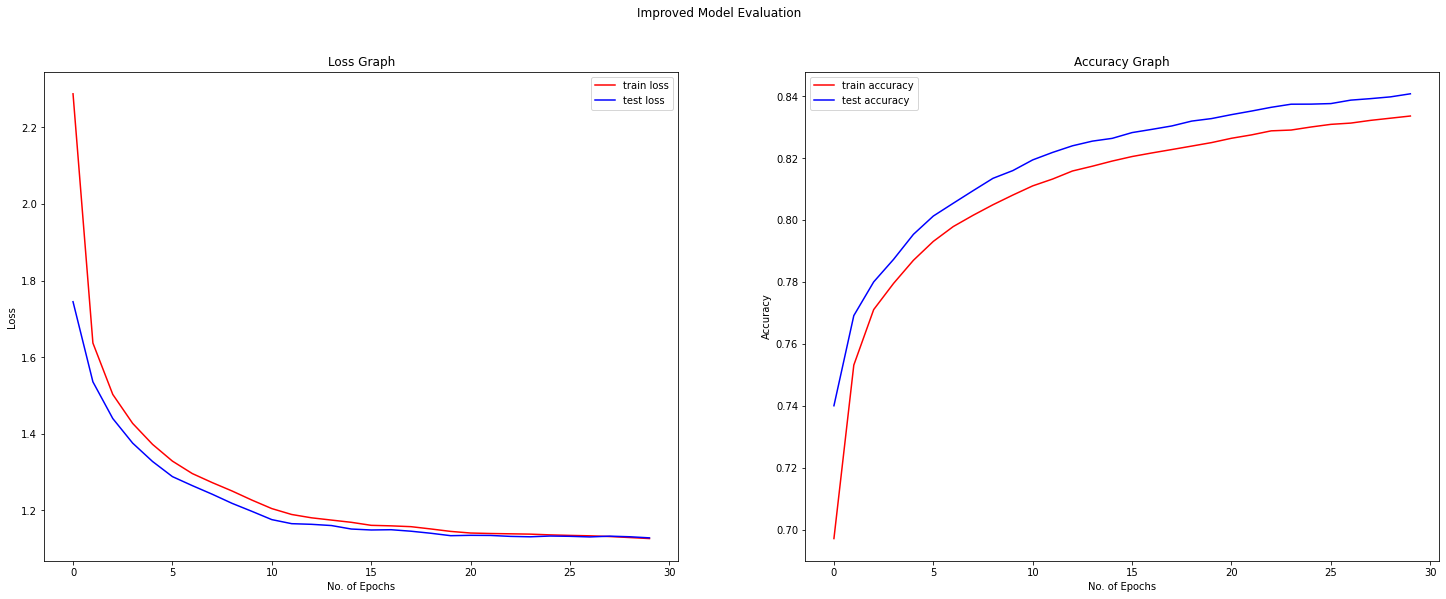

In [36]:
fig, ax = plt.subplots(1,2, figsize=(25,9))
plt.suptitle('Improved Model Evaluation')

plt.subplot(1,2,1)
plt.plot(improve_model_r.history['loss'],'r',label='train loss')
plt.plot(improve_model_r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

plt.subplot(1,2,2)
plt.plot(improve_model_r.history['accuracy'],'r',label='train accuracy')
plt.plot(improve_model_r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

plt.show()

`Dilihat dari hasilnya, model yang telah diimprove sudah lebih baik dibandingkan dengan base model dikarenakan sudah tidak overfit lagi melainkan bestfit. Dengan akurasi validasi sebesar 0,84 dan lossnya sebesar 1,1`

# vii. Model Inference

`Selanjutnya membuat model inference, dengan model encoder yang telah ditrain sebelumnya`

In [37]:
encoder_model = Model(encoder_inputs,encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          191680    
                                                                 
 batch_normalization (BatchN  (None, None, 32)         128       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 [(None, None, 64),        24832     
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
Total params: 216,640
Trainable params: 216,576
Non-trainable params: 64
____________________________________________________

In [38]:
#save model encoder
encoder_model.save('model_encoder.h5')

`Selanjutnya membuat model untuk model decoder inferencenya`

In [39]:
decoder_initial_state_h = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))

decoder_state_inputs = [decoder_initial_state_h, decoder_initial_state_c]

decoder_out, decoder_state_h, decoder_state_c = decoder_lstm(decoder_BN_3, initial_state=decoder_state_inputs)
decoder_states = [decoder_state_h, decoder_state_c]
decoder_final = decoder_dense(decoder_out)

decoder_model = Model(inputs = [decoder_inputs]+decoder_state_inputs, outputs=[decoder_final]+decoder_states)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     318048      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, None, 32)    128         ['embedding_1[0][0]']            
 rmalization)                                                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64)]         0           []                         

In [40]:
#save model decoder
decoder_model.save('model_decoder.h5')

In [41]:
encoder_model.trainable = False
decoder_model.trainable = False

`Selanjutnya memanggil kunci jawaban atau kamus setiap kata yang telah dibuat saat pelatihan model`

In [42]:
trs_words = dict((v,k) for k,v in deu_tokenizer.word_index.items())

In [43]:
#save kamus kata
pickle.dump(trs_words, open('translated_tokenized_decoder.pkl', 'wb'))

`Selanjutnya melakukan inference, yang pertama dilakuakan adalah membersihkan data inference yang akan digunakan dan dilakukan preprocessing yang sama dengan data training. Setelah itu, model encoder yang telah dibuat akan melakukan prediksi dengan mengambil state atau kunci apa saja yang ada di kalimat inference yang selanjutnya output dari model encoder akan dimasukan sebagai input pada model decoder untuk menemukan kata apa saja yang mewakilkan state tersebut lalu disusun dengan penanda start sebagai awal kalimat dan end sebagai akhir kalimat dengan referensi pada training sebelumnya`

In [46]:
#inference
text = 'how are you'
input_txt = clean_text(text)
inf = eng_tokenizer.texts_to_sequences([input_txt])
inf = pad_sequences( inf , maxlen=max_eng_len , padding='post' )

state_inf = encoder_model.predict(inf,verbose=0)

word = ''
sentences = []
target_seq = np.array([[deu_tokenizer.word_index['start']]])
while True:
  dec_out, h, c = decoder_model.predict([target_seq] + state_inf,verbose=0)

  wd_id = np.argmax(dec_out[0][0])
  word = trs_words[wd_id]
  sentences.append(word)

  target_seq = np.array([[wd_id]])
  state_inf = [h,c]

  if word == 'end' or len(sentences)>=15:

    if sentences[-1] == 'end':
      print(' '.join(sentences[:-1]))

    else:
      print(' '.join(sentences))
    break

wie geht es


`Pada contoh diatas, data inference menggunakan kalimat 'how are you' dan hasil terjemahan model 'wie geht es' yang berarti sama yaitu how are you. Model sudah dapat diimplementasikan pada data sesungguhnya` 

# viii. Kesimpulan

`Berdasarkan analisis dan overview yang didapat:`

- Data yang digunakan berasal dari ttp://www.manythings.org/anki/deu-eng.zip dengan jumlah total baris sebanyak 50000 baris karena keterbatasan waktu
- Tidak ada missing value maupun duplikat data 
- Kata bahasa inggris yang sering muncul adalah tom, need, want, love, know, now, let, now, go, dan one. Sedangkan bahasa jerman yang paling sering muncul adalah tom, ich, bin, habe, dan ist
- Dikedua bahasa mempunyai proporsi yang sama, sesuai dengan panjang kata di masing masing kalimatnya. Kalimat yang mempunyai 4 kata merupakan kalimat yang paling sering muncul baik dibahasa inggris maupun bahasa german
- Jumlah kosakata bahasa inggris pada data sebanyak 5990 kata sedangkan bahasa german lebih banyak yaitu 9939 kata
- Jumlah kata yang paling panjang disatu kalimat bahasa inggris adalah 7 kata sedangakan bahasa jerman adalah 17 kata
- Model yang digunakan mempunyai batch normalization dan embedding di masing masing model encoder dan model decoder. Dan juga menggunakan 2 layer LSTM dengan dimensi sebanyak 64 neuron.
- Optimizer yang digunakan adalah RMSprop dan dilakukan iterasi sebanyak 30 kali
- Total waktu yang diperlukan untuk mentraining model sekitar 450 detik atau 7,5 menit
- Jumlah params yang digunakan pada training model adalah 1,205,683 params
- Hasil evaluasi model yang telah diimprove atau yang digunakan, didapatkan nilai akurasinya yaitu 0,84 dan lossnya sebesar 1,1. Dilihat dari hasilnya, model didapatkan bersifat bestfit dan mempunyai akurasi diatas 0,8 yang berati model tersebut sudah dapat dikatakan cukup baik.
- Pada hasil model inferencenya, model tersebut sudah dapat mentranslate kata `how are you` dengan `wie geht es` yang berarti cukup sama dengan aslinya.
- Model masih sangat masih bisa diimprove lagi dengan menggunakan 255.000 data dan mentunning kembali modelnya agar mendapatkan hasil yang diinginkan